In [277]:
# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import logging
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from tqdm import tqdm
# MNE functions
import mne
from mne import Epochs,find_events
from mne.decoding import Vectorizer

#MNE XDF Importer
from mne_import_xdf import *

# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay



from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, train_test_split
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn, Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
import mne

from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP



import pyxdf
import PyQt5

from easygui import *

import pathlib

# For interactive plots
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')

from os import listdir
from os.path import isfile, join
import json

#import moab to get the filterbank implementation: 
from moabb.pipelines.utils import FilterBank

#imports for precision_recall_curve related plot: 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, precision_recall_curve,PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

import copy

In [2]:
#define paths: 
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'
figure_outputs_path=current_path / 'figures_outputs'
hyper_param_search_output=current_path / 'hyper_param_search_outputs'
#extract all recorded files and subject names
recording_files = [f for f in listdir(recording_path) if isfile(join(recording_path, f)) and ('.xdf' in f)]
if not(figure_outputs_path.exists()):
    print('the output folder does not exists:  ',figure_outputs_path)

if not(hyper_param_search_output.exists()):
    print('the output folder does not exists:  ',hyper_param_search_output)


print('all available recording files',recording_files)
subject_names=[r.split('_')[0] for r in recording_files]
print('only subjects IDS:',subject_names)

all available recording files ['Gilad_ses-1_task-mi_run-001_eeg.xdf', 'Gilad_ses-1_task-mi_run-002_eeg.xdf', 'Gilad_ses-1_task-mi_run-003_eeg.xdf', 'Gilad_ses-1_task-mi_run-004_eeg.xdf', 'G_BCI_No_AO.xdf', 'Neta_AO_1Hand.xdf', 'Neta_AO_2Hands.xdf', 'Neta_NoAO_1Hand.xdf', 'Neta_NoAO_2Hands.xdf', 'NH_Block_1.xdf', 'NH_Block_2.xdf', 'NH_Block_3.xdf', 'OldGilad_AO.xdf', 'Ro555ei_P300.xdf', 'Ro555ei_P300_1_24_05.xdf', 'Ron-Block_1.xdf', 'Ron-Block_2.xdf', 'Ron-Block_3.xdf', 'Ron-Block_4.xdf', 'sub-Roei_ses-MI1_task-Default_run-001_eeg.xdf', 'sub-Roei_ses-MI2_task-Default_run-001_eeg.xdf', 'sub-Roei_ses-Mi3_task-Default_run-001_eeg.xdf']
only subjects IDS: ['Gilad', 'Gilad', 'Gilad', 'Gilad', 'G', 'Neta', 'Neta', 'Neta', 'Neta', 'NH', 'NH', 'NH', 'OldGilad', 'Ro555ei', 'Ro555ei', 'Ron-Block', 'Ron-Block', 'Ron-Block', 'Ron-Block', 'sub-Roei', 'sub-Roei', 'sub-Roei']


In [14]:
# Initial defitions: 
print('filenames:\n',recording_files)
print('names:\n',subject_names)

Use_test_grid=False #change to False when you want to use the real grid_search and not a toy one: 

#define the electdode groups: the key can be anything, the values should be a list of electrodes
Electorde_Groups = {'FP': ['Fp1', 'Fp2'],
                   'AF': ['AF7', 'AF3', 'AFz', 'AF4', 'AF8'],
                   'F' : ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],
                   'FC': ['FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT7','FT8'],
                   'C' : ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4' ,'C6'],
                   'CP': ['CP5', 'CP3', 'CP1','CPz', 'CP2', 'CP4', 'CP6'],
                   'P' : ['P7', 'P5','P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
                   'PO': ['PO7', 'PO3', 'POz', 'PO4', 'PO8'],
                   'O' : ['Oz', 'O2', 'O1', 'Iz']
                  } 

#define the grid search (dont go all at once because some params are not relevant to other params and might just increase running time: 
# i.e if using fbcsp, the n_components_grid paramater is not used, so if it has more than 1 value, it will run the fbcsp twice while changing a paramter that does not effect the calculation)
grid_search_dict=OrderedDict()
grid_search_dict={'filter_methods':['iir'], #['irr' or 'fir']
                'run_csd':[True, False],
                'pipeline_name':['csp+lda','ts+lda','fbcsp+lda'], #these classifiers pipelines are defined in "run_windowed_classification_on_fold"
                #things to do: filter bank csp + lda, csp+ts+lda
                'bandpass_borders_grid':[[7,32]], #each list defines the low and high cutoffs
                'Electorde_Groups_names_grid':['C','PO'], #each "name" refers to an elec group defined above
                'n_components_grid':[4], #the n component options for the csp classifier
                'n_components_fbcsp_grid':[2,3], # the n components options to use in the fbcsp classifier (n * filter_bank_bands)\
                'filters_bands':[[8,12]],#[[[8, 12], [12, 20], [20, 32]]],
                'epoch_tmins_and_maxes_grid':[[-3,4]], #times (sec: pre,post) for initial epoching (this should be the longest epoch as the windowed prediction will be tested on it)
                'classifier_training_windows_grid':[[1 , 2],[1,3]], #what times(sec: start,end) to use for the classifer training (data augmentation is also using this window)
                'augmentation_windows_grid':[[0,0],[0.5,0.5]], #referes to proportions (win_len,win_step) of sfreq, [1,1] means taking the classification epochs, and creating 1 second long epochs with 1 second long steps
                'windowed_prediction_params':[[0.5,0.1],[0.75,0.1],[1,0.1]]} #refers to prportions (win_len,win_step) of sfreq to try and predict i.e. 0.5 = half a second window, with a 100ms steps  

#here you can define a test grid (make it small so it wont take long, and use it to check that everything is working) 
test_grid_search_dict={'filter_methods':['fir'], #['irr' or 'fir']
                'run_csd':[True],
                'pipeline_name':['csp+lda'], #these classifiers pipelines are defined in "run_windowed_classification_on_fold
                #things to do: filter bank csp + lda, csp+ts+lda
                'bandpass_borders_grid':[[8,32]], #each list defines the low and high cutoffs
                'Electorde_Groups_names_grid':['C','PO'], #each "name" refers to an elec group defined above
                'n_components_grid':[4], #the n component options for the csp classifier
                'n_components_fbcsp_grid':[3], # the n components options to use in the fbcsp classifier (n * filter_bank_bands)
                'filters_bands':[[[8, 12], [12, 20], [20, 32]]],
                'epoch_tmins_and_maxes_grid':[[-3,5]], #times (sec: pre,post) for initial epoching (this should be the longest epoch as the windowed prediction will be tested on it)
                'classifier_training_windows_grid':[[0,2]], #what times(sec: start,end) to use for the classifer training (data augmentation is also using this window)
                'augmentation_windows_grid':[[1,0.1]], #referes to proportions (win_len,win_step) of sfreq, [1,1] means taking the classification epochs, and creating 1 second long epochs with 1 second long steps
                'windowed_prediction_params':[[1,0.1]]} #refers to prportions (win_len,win_step) of sfreq to try and predict i.e. 0.5 = half a second window, with a 100ms steps  

if Use_test_grid: 
   print('\n######\nusing a test grid search\n######\n')
   grid_search_dict=test_grid_search_dict

all_options=[list(range(len(val))) for key,val in grid_search_dict.items()]
print(f'grid options {all_options}')
#get all possible grid_search combinations: 
all_grid_combinations = list(itertools.product(*all_options))
print(f'number of grid search iterations: {len(all_grid_combinations)}')
print('Grid info:',grid_search_dict)
#save the hyper_grid_search: 
with open(hyper_param_search_output/'grid_search_info.json', 'w') as file:
    json.dump(grid_search_dict, file)

filenames:
 ['Gilad_ses-1_task-mi_run-001_eeg.xdf', 'Gilad_ses-1_task-mi_run-002_eeg.xdf', 'Gilad_ses-1_task-mi_run-003_eeg.xdf', 'Gilad_ses-1_task-mi_run-004_eeg.xdf', 'G_BCI_No_AO.xdf', 'Neta_AO_1Hand.xdf', 'Neta_AO_2Hands.xdf', 'Neta_NoAO_1Hand.xdf', 'Neta_NoAO_2Hands.xdf', 'NH_Block_1.xdf', 'NH_Block_2.xdf', 'NH_Block_3.xdf', 'OldGilad_AO.xdf', 'Ro555ei_P300.xdf', 'Ro555ei_P300_1_24_05.xdf', 'Ron-Block_1.xdf', 'Ron-Block_2.xdf', 'Ron-Block_3.xdf', 'Ron-Block_4.xdf', 'sub-Roei_ses-MI1_task-Default_run-001_eeg.xdf', 'sub-Roei_ses-MI2_task-Default_run-001_eeg.xdf', 'sub-Roei_ses-Mi3_task-Default_run-001_eeg.xdf']
names:
 ['Gilad', 'Gilad', 'Gilad', 'Gilad', 'G', 'Neta', 'Neta', 'Neta', 'Neta', 'NH', 'NH', 'NH', 'OldGilad', 'Ro555ei', 'Ro555ei', 'Ron-Block', 'Ron-Block', 'Ron-Block', 'Ron-Block', 'sub-Roei', 'sub-Roei', 'sub-Roei']
grid options [[0], [0, 1], [0, 1, 2], [0], [0, 1], [0], [0, 1], [0], [0], [0, 1], [0, 1], [0, 1, 2]]
number of grid search iterations: 288
Grid info: {'filt

### define trigger and bad electrodes information

In [15]:
#define the trigger info per participant
#new subjects should be added here, untill we decide on a single trigger... 
def define_events_trigger_values_per_recording_file(recording_file):
    events_dictionary={'Dekel_AO.xdf':{3:'left',6:'right'},
                    'Dekel_AoNoMI.xdf':{3:'left',6:'right'},
                    'Dekel_NoAO.xdf':{3:'left',6:'right'}, 
                    'Gilad_AO.xdf':{4:'left',7:'right'}, 
                    'Neta_AO_1Hand.xdf':{2:'close',5:'open'},
                    'Neta_AO_2Hands.xdf':{3:'left',6:'right'},
                    'Neta_NoAO_1Hand.xdf':{2:'close',5:'open'},
                    'Neta_NoAO_2Hands.xdf':{3:'left',6:'right'},
                    'Ron-Block_2.xdf':{3:'left',6:'rest',7:'right'},
                    'Ron-Block_3.xdf':{3:'left',6:'rest',7:'right'},
                    'Ron-Block_4.xdf':{3:'left',6:'rest',7:'right'},
                    'sub-Roei_ses-MI1_task-Default_run-001_eeg.xdf': {2:'left',5:'rest',6:'right'}, 
                    'sub-Roei_ses-MI2_task-Default_run-001_eeg.xdf': {3:'left',6:'rest',7:'right'},  
                    'sub-Roei_ses-Mi3_task-Default_run-001_eeg.xdf': {3:'left',6:'rest',7:'right'},
                    'NH_Block_1.xdf': {3:'left',6:'rest',7:'right'},
                    'NH_Block_2.xdf': {3:'left',6:'rest',7:'right'},
                    'NH_Block_3.xdf': {3:'left',6:'rest',7:'right'}}
    if recording_file not in events_dictionary.keys():
        raise Exception(f'the current recording file {recording_file} does not have a defined triggers in the function "define_events_triggers_Values_per_recorindg_file')
    
    trigger_info_dict=events_dictionary[recording_file]
    return trigger_info_dict
    

#define what electdodes should be excluded (based on whatever method you'd like (probably visual inspection of the recordings))
def get_subject_bad_electrodes(subject):
    elecs_to_drop={}
    #define here the subject specific electdodes to make sure are removed from the data: 
    bad_elecs_dict={'Dekel':{'FT10', 'TP10', 'FT9'},
                    'Gilad':{'FT10', 'TP10', 'FT9', 'TP9'},
                    'Neta':{'TP9'},
                    'Ron-Block':{'PO7'},
                    'sub-Roei': {'TP9'},
                    'NH' : {'TP7'}}
    if subject in bad_elecs_dict.keys():
        subject_bad_electrodes=bad_elecs_dict[subject]
    else: 
        subject_bad_electrodes={}
        print('note that no bad electrodes were defined for the current subject:',subject)
    return subject_bad_electrodes   
    

In [16]:
def set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict):
    curr_grid_comb=all_grid_combinations[iteration_ind]
    print(f'setting up current params: iteration {iteration_ind} - grid settings: {curr_grid_comb}')
    #create a dictionary from the current grid combination (note that the dictionary is ordered): 
    iteration_dictionary={key:val[inner_ind] for ((key,val),inner_ind) in zip(grid_search_dict.items(),curr_grid_comb)}
   
    #extract the paramaters for the current iteration: 
    LowPass=iteration_dictionary['bandpass_borders_grid'][0]
    HighPass=iteration_dictionary['bandpass_borders_grid'][1]
    PerformCsd=iteration_dictionary['run_csd']
    filter_method=iteration_dictionary['filter_methods']

    #extract current electrodes (allow for combination of electrode groups i.e 'C+AF+F')
    Electorde_Group_name=iteration_dictionary['Electorde_Groups_names_grid'] #['FP', 'AF', 'F', 'FC', 'C', 'CP', 'P', 'PO', 'O']
    Electorde_Group=[]
    for cur_elec_group_name in Electorde_Group_name.split('+'):
        Electorde_Group=Electorde_Group+Electorde_Groups[cur_elec_group_name]
    classifier_window_s=iteration_dictionary['classifier_training_windows_grid'][0]
    classifier_window_e=iteration_dictionary['classifier_training_windows_grid'][1]
    epoch_tmin=iteration_dictionary['epoch_tmins_and_maxes_grid'][0]
    epoch_tmax=iteration_dictionary['epoch_tmins_and_maxes_grid'][1]
    n_components=iteration_dictionary['n_components_grid']
    n_components_fbcsp=iteration_dictionary['n_components_fbcsp_grid']
    #define the current augmentation paramaters to test: note that they are defined by samples
    augmentation_params={'win_len':iteration_dictionary['augmentation_windows_grid'][0],
                        'win_step':iteration_dictionary['augmentation_windows_grid'][1]}
    #define the windowed prediction paramaters: #here they are defined as proportions of the sampling frequency
    windowed_prediction_params={'win_len':iteration_dictionary['windowed_prediction_params'][0],
                                'win_step':iteration_dictionary['windowed_prediction_params'][1]}
    #get the current pipeline name: 
    pipeline_name=iteration_dictionary['pipeline_name']
    filters_bands=iteration_dictionary['filters_bands']                          
    #set paramaters dict for current run: 
    params_dict={'LowPass': LowPass,
                'HighPass': HighPass,
                'PerformCsd':PerformCsd,
                'filter_method':filter_method,
                'n_components':n_components,
                'n_components_fbcsp':n_components_fbcsp,
                'filters_bands':filters_bands,
                'Electorde_Group':Electorde_Group,
                'Electorde_Group_name':Electorde_Group_name,
                'epoch_tmin':epoch_tmin,
                'epoch_tmax':epoch_tmax,
                'classifier_window_s':classifier_window_s,
                'classifier_window_e':classifier_window_e,
                'augmentation_params':augmentation_params,
                'windowed_prediction_params':windowed_prediction_params,
                'pipeline_name':pipeline_name}

    return params_dict

In [305]:
#need to define a preprocessing function that can accept several participant files and add them to a single structure. 
def run_pre_processing_extract_validation_set(recording_path,current_path,params_dict):

    #extract the current run paramaters: 
    Subject=params_dict['subject']
    PerformCsd=params_dict['PerformCsd']
    LowPass, HighPass, filter_method = params_dict['LowPass'],params_dict['HighPass'],params_dict['filter_method']
    tmin=params_dict['epoch_tmin']
    tmax=params_dict['epoch_tmax']

    #events_trigger_dict=define_events_trigger_values_per_recording_file(params_dict['recording_file']) # could be redundant after changes to event_dict
    #events_trigger_dict={val:key for key,val in events_trigger_dict.items()}

    #read the file:
    Raw=read_raw_xdf(recording_path / params_dict['recording_file'])
    #remove non existent channels: 
    Raw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
    #set the correct (Brainvision Montage) montage:
    montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 
    #rename channels for consistency: 
    mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
    Raw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)

    print('\n###########################################################')
    print('removing subject sepecific bad electrodes from the raw data')
    #drop bad electrodes according to the current subject name: 
    print('\n###########################################################')
    print('removing bad channels from epochs:')
    curr_elecs_in_epochs_set=set(Raw.info['ch_names'])
    elecs_to_remove=get_subject_bad_electrodes(Subject)
    elecs_to_drop=curr_elecs_in_epochs_set.intersection(elecs_to_remove)

    if len(elecs_to_drop)>0: 
        Raw.drop_channels(list(elecs_to_drop))
    Raw.drop_channels(Raw.info['bads'])

    #do csd: 
    if (PerformCsd):
        print('\n###########################################################')
        print('running csd')
        Raw_CSD = mne.preprocessing.compute_current_source_density(Raw) ## Compute CSD
    else :
        print('\n###########################################################')
        print('not using csd')
        Raw_CSD = Raw

    print('\n###########################################################')
    print('filtering the data')  
    unfiltered_Raw_CSD=Raw_CSD.copy()
    Raw_CSD_Filtered = unfiltered_Raw_CSD.filter(LowPass, HighPass, method=filter_method)

    #extract filterbank feequencies:
    filters_bands=tuple(params_dict['filters_bands'])
    filtered_data_band_passed=[]
    for i,(LowPass,HighPass) in enumerate(filters_bands):
        unfiltered_Raw_CSD=Raw_CSD.copy()
        Raw_CSD_Filtered_band= unfiltered_Raw_CSD.filter(LowPass, HighPass, method=filter_method)
        filtered_data_band_passed.append(Raw_CSD_Filtered_band)

    events_from_annot,event_dict = mne.events_from_annotations(Raw_CSD_Filtered)
    print('\n###########################################################')
    print('extracting event info:',event_dict)
    # Select relevant events for epoching
    desired_events = ['Left', 'Resting', 'Right'] 
    events_trigger_dict = {key: event_dict[key] for key in event_dict.keys() if key in desired_events}
    print('\n###########################################################')
    selected_elecs=params_dict['Electorde_Group']

    #filter bank related: 
    filter_bank_epochs=[]
    for filtered_data_band in filtered_data_band_passed:
        epochs = mne.Epochs(filtered_data_band, events_from_annot,picks=params_dict['Electorde_Group'], preload = True,baseline= None, tmin=tmin, tmax=tmax, event_id=events_trigger_dict,detrend=0)
        filter_bank_epochs.append(epochs)

    print(f'epoching + selecting current electodes set for analysis:\n{selected_elecs}')
    epochs = mne.Epochs(Raw_CSD_Filtered, events_from_annot,picks=params_dict['Electorde_Group'], preload = True,baseline= None, tmin=tmin, tmax=tmax, event_id=events_trigger_dict,detrend=0)


    #this section drops electrodes after epoching: but currently we drop all bad electrodes from the raw data
    print('\n###########################################################')
    print('removing bad channels from epochs:')
    curr_elecs_in_epochs_set=set(epochs.info['ch_names'])
    elecs_to_remove=get_subject_bad_electrodes(Subject)
    elecs_to_drop=curr_elecs_in_epochs_set.intersection(elecs_to_remove)

    if len(elecs_to_drop)>0:
        epochs.info['bads']=elecs_to_drop
        epochs.drop_channels(epochs.info['bads'])
        print('\n###########################################################')
        print(f'Removed: {elecs_to_drop} from the current selected electrodes: {curr_elecs_in_epochs_set} from the overall set of bad electrodes {elecs_to_remove}')
        print('#############################################################')
    
        #filter bank related: 
        filter_bank_epochs_after_elec_drops=[]
        for curr_epochs in filter_bank_epochs:
            curr_epochs.info['bads']=elecs_to_drop
            curr_epochs.drop_channels(epochs.info['bads'])
            filter_bank_epochs_after_elec_drops.append(curr_epochs)    
    else: 
        #filter bank related: 
        filter_bank_epochs_after_elec_drops=[]
        for curr_epochs in filter_bank_epochs:
            filter_bank_epochs_after_elec_drops.append(curr_epochs)  

        print('\n###########################################################')
        print(f'the current selected electrodes: {curr_elecs_in_epochs_set} allready exclude the requested electrodes to remove {elecs_to_remove}')
        print('#############################################################')

    #extract the validation set: we will use it only after selecting all hyper paramaters to get a better representation of out-of-sample performence: 
    #using a very small test size as we currently mostly look at the CV scores: 
    data_df=pd.DataFrame(data=epochs.events[:, -1], columns=['label'] ,index=range(len(epochs.events[:, -1])))
    data_df['original_trial_ind']=range(len(epochs.events[:, -1]))
    train,validation=train_test_split(data_df,shuffle=True,random_state=42,stratify=data_df['label'],test_size=0.2)
 
    train_inds=train['original_trial_ind'].values
    validation_inds=validation['original_trial_ind'].values
    print(f'putting aside 20% of the data: trial numbers are:\n {validation_inds}\n')
    print(f'remaining 80% of the trials go into training for cv:\n {train_inds}\n')

    return_dict={'train_inds':train_inds,
                'validation_inds':validation,
                'epochs':epochs,
                'filter_bank_epochs':filter_bank_epochs_after_elec_drops,
                'events_triggers_dict':events_trigger_dict}
    return train_inds,validation_inds,return_dict


In [284]:
def crop_the_data(epochs,train_inds,validation_inds,full_epoch_tmin=0,full_epoch_tmax=4,tmin=1,tmax=2):
    #returns a dictionary containing the cropped and uncropped versions of the validation and training epochs.
    tmin=float(tmin)
    tmax=float(tmax)
    #save uncropped versions of the data: 
    #save the training data:
    train_set_data_uncroped=epochs.get_data()[train_inds]
    train_set_labels_uncroped=epochs.events[train_inds,-1]

    #save the validation data: 
    validation_set_data_uncroped=epochs.get_data()[validation_inds]
    validation_Set_labels_uncroped=epochs.events[validation_inds,-1]

    #crop the epochs (use the epochs structure)
    epochs_cropped = epochs.copy().crop(tmin=full_epoch_tmin, tmax=full_epoch_tmax)

    #from here on - we extract the data as matrices (not epoch object anymore):

    #save the training data:
    train_set_data=epochs_cropped.get_data()[train_inds]
    train_set_labels=epochs_cropped.events[train_inds,-1]

    #save the validation data: 
    validation_set_data=epochs_cropped.get_data()[validation_inds]
    validation_set_labels=epochs_cropped.events[validation_inds,-1]

    return_dict={'train_set_data_uncroped':train_set_data_uncroped,
                'train_set_labels_uncroped':train_set_labels_uncroped,
                'validation_set_data_uncroped':validation_set_data_uncroped,
                'validation_Set_labels_uncroped':validation_Set_labels_uncroped,
                'epochs_cropped':epochs_cropped,
                'train_set_data':train_set_data,
                'train_set_labels':train_set_labels,
                'validation_set_data':validation_set_data,
                'validation_set_labels':validation_set_labels}
    return return_dict

def plot_accuracy_over_time(scores_windows,w_times,params_dict,axes_handle):
    #this function accepts the scores windows (a list of n folds - each giving a score on a time window)
    #it converts it to a long dataframe with the following columns: fold_id,Time,Accuracy
    #then it uses the long format to plot using seaborn lineplot and get a confidence interval
    times_col_names=[np.round(w_times[s],2) for s in range(len(w_times))]
    scores_windows_array=np.squeeze(np.array(scores_windows))
    scores_windows_df=pd.DataFrame(columns=times_col_names,data=scores_windows_array)
    scores_windows_df['fold_id']=range(len(scores_windows_df))
    longform_scores_windows_df=pd.melt(scores_windows_df, id_vars='fold_id', value_vars=scores_windows_df.columns)
    longform_scores_windows_df.rename(columns={'variable':'Time','value':'Accuracy'},inplace=True)
    sns.lineplot(data=longform_scores_windows_df,x='Time',y='Accuracy',ax=axes_handle)

    if any(w_times>0):
        onset_location=np.round(w_times[w_times>=0][0],2) ## find the onest (assuming 0 in epoch time)
        axes_handle.axvline(onset_location, linestyle='--', color='k', label='Onset') 
        axes_handle.axvline(onset_location+1, linestyle=':', color='k', label='ArrowGone') ## adjusted 'Onset' to 3 seconds for augmented data
    axes_handle.axhline(0.5, linestyle='-', color='k', label='Chance')
    axes_handle.set_xlabel('time (s)')
    axes_handle.set_ylabel('classification accuracy')
    axes_handle.set_title('Classification score over time')
    axes_handle.set_ylim([0.25, 0.9])
    
def run_windowed_classification_on_fold(fold_train_data_x,fold_train_data_y,fold_test_data_x_uncroped,fold_test_data_y,params_dict,w_start,w_length):
    #note that this is currently the  function that really does the classification and extracts the performence measure (the previous calls to run_lda.... for example, are just tests)
    curr_classifier_name=params_dict['pipeline_name']
    if curr_classifier_name=='csp+lda':  
        #define the classifier components:  
        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=params_dict['n_components'], reg=None, log=True, norm_trace=False)
        #define the pipeline: 
        clf = Pipeline([('csp',csp),('classifier_LDA',lda)])
    elif curr_classifier_name=='ts+lda':
        #define the classifier components:  
        covest = Covariances()
        ts = TangentSpace()
        lda = LinearDiscriminantAnalysis()
        #define the pipeline: 
        clf = Pipeline([('conv',covest),('ts', ts), ('LDA', lda)])
    elif curr_classifier_name=='fbcsp+lda':
        #define the classifier components: 
        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=params_dict['n_components_fbcsp'], reg=None, log=True, norm_trace=False)
        fb=FilterBank(csp)
        #define the pipeline: 
        clf = Pipeline([('fbcsp',fb),('classifier_LDA',lda)])
    else: 
        raise Exception(f'the requested classifier is not defined in "run_windowed_classification_on_fold": {curr_classifier_name}')
    
    #get string labels instead of numeric (so the classifier will have an informative clf.classes_ )
    triggers_label_dict={val:key for key,val in params_dict['preprocessing_dict']['events_triggers_dict'].items()} 
    fold_train_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in fold_train_data_y])  
    #fit the selected classifier: 
    
    clf.fit(fold_train_data_x, fold_train_data_y_labels)
    # running classifier: test classifier on sliding window

    #get string labels instead of numeric for the test
    fold_test_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in fold_test_data_y])
    fold_windowed_scores,confusion_metrices_per_window=run_windowed_pretrained_classifier(clf,fold_test_data_x_uncroped,fold_test_data_y_labels,w_start,w_length)
    return fold_windowed_scores,confusion_metrices_per_window,clf

def run_windowed_pretrained_classifier(clf,x_uncropped,y,w_start,w_length):
    scores_per_time_window = []
    confusion_metrices_per_window=[]
    if len(x_uncropped.shape)==3: #reshape it as if it was a 4d matrix (assuming the 4th dimention is the filterbank)
        x_uncropped=x_uncropped.reshape(list(x_uncropped.shape)+[1])
    for n in w_start:
        fold_data=np.squeeze(x_uncropped[:, :, n:(n + w_length),:]) #using squeeze here so that if the 4th dimention size is 1 it will reduce it to a 3d vector
        #if the classifier uses a filterbank its input should be 4d (trials,channels,timesteps,filter_bands) and if it doesnt its 3d (trials,channels,timesteps)
        fold_score_on_time_window=clf.score(fold_data, y)
        #append the score for the LDA, using this csp to predict the relevant test scores: 
        scores_per_time_window.append(fold_score_on_time_window)
        confusion_mat=confusion_matrix(y,clf.predict(fold_data),labels=clf.classes_)
        confusion_metrices_per_window.append(confusion_mat)
    return scores_per_time_window,confusion_metrices_per_window

def augment_data(augmentation_params,data_x_to_augment,y,sfreq):
    #do augmentation: 
    if (augmentation_params['win_step']==0 or augmentation_params['win_len']==0): #check if augmentation is not requested/invalid:
        augmented_x=data_x_to_augment
        augmented_y=y
    else: #augmentation requested
        #set up the augmentation window boundaries based on the augmentation paramaters:                      
        aug_epochs_s=np.arange(0,data_x_to_augment.shape[2],augmentation_params['win_step']*sfreq)
        aug_epochs_e=np.array([a+augmentation_params['win_len']*sfreq for a in aug_epochs_s])
        #remove start and ends that exceeds the relevant epoch lengths: 
        aug_epochs_s=aug_epochs_s[aug_epochs_e<data_x_to_augment.shape[2]]
        aug_epochs_e=aug_epochs_e[aug_epochs_e<data_x_to_augment.shape[2]]

        #pile all augmented (sub windows) to have the regular structure of epochs (>original due to augmentation,channels,samples)
        data_fold_x_augmented=[]
        data_fold_y_augmented=[]
        for aug_s,aug_e in zip(aug_epochs_s,aug_epochs_e):
            if len(data_x_to_augment.shape)==3:
                data_x_in_cur_window=data_x_to_augment[:,:,int(aug_s):int(aug_e)]
            elif len(data_x_to_augment.shape)==4: #with filterbank: 
                data_x_in_cur_window=data_x_to_augment[:,:,int(aug_s):int(aug_e),:]
            data_y_in_cur_window=y
            data_fold_x_augmented.append(data_x_in_cur_window)
            data_fold_y_augmented.append(data_y_in_cur_window)

        augmented_x=np.concatenate(data_fold_x_augmented,axis=0)
        augmented_y=np.concatenate(data_fold_y_augmented)
    return augmented_x,augmented_y


def run_windowed_classification_aug_cv(epochs_cropped,cv_split,train_set_data,train_set_labels,train_set_data_uncroped,params_dict):
    augmentation_params=params_dict['augmentation_params']
    windowed_prediction_params=params_dict['windowed_prediction_params']
    win_len=windowed_prediction_params['win_len']
    win_step=windowed_prediction_params['win_step']
    
    sfreq = epochs_cropped.info['sfreq']
    w_length = int(sfreq * win_len)   # running classifier: window length
    w_step = int(sfreq * win_step)  # running classifier: window step size
    w_start = np.arange(0, train_set_data_uncroped.shape[2] - w_length, w_step)
    print('uncroped train set length = ',train_set_data_uncroped.shape[2])

    scores_windows = []
    folds_confusion_metrices_per_window=[]
    #this section first extracts each CV fold, only then it augments it (to avoid data leakage)
    for train_idx, test_idx in cv_split:
        #seperate the cv fold for labels - train-test:
        y_train, y_test = train_set_labels[train_idx], train_set_labels[test_idx] 
        #seperate the cv fold for features information: 
        if len(train_set_data.shape)==3:
            data_fold_x_train_to_augment = train_set_data[train_idx,:,:]
        elif len(train_set_data.shape)==4: #there are filter bank info in the data: 
            data_fold_x_train_to_augment = train_set_data[train_idx,:,:,:] 
        #do augmentation: 
        augmented_x,augmented_y=augment_data(augmentation_params,data_fold_x_train_to_augment,y_train,sfreq)
        #run classifier on the data fold
        curr_scores_windows,confusion_metrices_per_window,_=run_windowed_classification_on_fold(augmented_x,augmented_y,train_set_data_uncroped[test_idx],y_test,params_dict,w_start,w_length)         
        scores_windows.append(curr_scores_windows)
        folds_confusion_metrices_per_window.append(confusion_metrices_per_window)
    w_times = (w_start + w_length / 2.) / sfreq + params_dict['epoch_tmin']
    return scores_windows,folds_confusion_metrices_per_window,w_times


def run_windowed_classification_aug(epochs_cropped,train_set_data,train_set_labels,train_set_data_uncroped,test_y,params_dict):
    augmentation_params=params_dict['augmentation_params']
    windowed_prediction_params=params_dict['windowed_prediction_params']
    win_len=windowed_prediction_params['win_len']
    win_step=windowed_prediction_params['win_step']
    sfreq = epochs_cropped.info['sfreq']
    w_length = int(sfreq * win_len)   # running classifier: window length
    w_step = int(sfreq * win_step)  # running classifier: window step size
    w_start = np.arange(0, train_set_data_uncroped.shape[2] - w_length, w_step)
    w_times = (w_start + w_length / 2.) / sfreq + params_dict['epoch_tmin']

    augmented_x,augmented_y=augment_data(augmentation_params,train_set_data,train_set_labels,sfreq)
    scores_windows,confusion_metrices_per_window,trained_clf=run_windowed_classification_on_fold(augmented_x,augmented_y,train_set_data_uncroped,test_y,params_dict,w_start,w_length)         

    return scores_windows,confusion_metrices_per_window,w_times,trained_clf

In [76]:
def run_training_and_classification_on_selected_params(params_dict,preprocessing_dict,to_plot=False,figure_outputs_path='',fig_name='temp'):
    epochs_copy=preprocessing_dict['epochs']
    train_inds=preprocessing_dict['train_inds']
    validation_inds=preprocessing_dict['validation_inds']['original_trial_ind'].values

    #crop the data according to the training window: 
    returned_dict=crop_the_data(epochs_copy,train_inds,validation_inds,params_dict['classifier_window_s'],params_dict['classifier_window_e']) #two more paramters here are tmin and tmax which are not used apparently. 
    train_set_data_uncropped=returned_dict['train_set_data_uncroped']
    epochs_cropped=returned_dict['epochs_cropped']
    train_set_data=returned_dict['train_set_data']
    train_set_labels=returned_dict['train_set_labels']

    validation_set_labels=returned_dict['validation_set_labels']
    validation_set_data_uncropped=returned_dict['validation_set_data_uncroped']
    #define cv on the data: 
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(train_set_data,train_set_labels)

    #filter bank related:
    if params_dict['pipeline_name']=='fbcsp+lda': 
        train_set_data_fb=[]
        train_set_data_uncropped_fb=[]
        validation_set_data_fb=[]
        validation_set_data_uncropped_fb=[]
        for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
            returned_dict_temp=crop_the_data(filtered_data_band_epoch,train_inds,validation_inds, params_dict['classifier_window_s'],params_dict['classifier_window_e'])
            #extract the train set data: 
            train_set_data_uncroped_temp=returned_dict_temp['train_set_data_uncroped']
            train_set_data_temp=returned_dict_temp['train_set_data']
            train_set_data_fb.append(train_set_data_temp)
            train_set_data_uncropped_fb.append(train_set_data_uncroped_temp)
            #extract the validation set data: 
            validation_set_data_uncroped_temp=returned_dict_temp['validation_set_data_uncroped']
            validation_set_data_temp=returned_dict_temp['validation_set_data']
            validation_set_data_fb.append(validation_set_data_temp)
            validation_set_data_uncropped_fb.append(validation_set_data_uncroped_temp)
        #create a 4d matrix of train data:     
        train_set_data_4d_array= np.transpose(np.array(train_set_data_fb),(1,2,3,0))
        train_set_data_uncropped_4d_array=np.transpose(np.array(train_set_data_uncropped_fb),(1,2,3,0)) 
        train_set_data=train_set_data_4d_array
        train_set_data_uncropped=train_set_data_uncropped_4d_array
        #create a 4d matrix of validation data: 
        validation_set_data_4d_array= np.transpose(np.array(validation_set_data_fb),(1,2,3,0))
        validation_set_data_uncropped_4d_array=np.transpose(np.array(validation_set_data_uncropped_fb),(1,2,3,0)) 
        validation_set_data_uncropped=validation_set_data_uncropped_4d_array

    #get scores over time using CV: 
    scores_windows,folds_confusion_metrices_per_window,w_times=run_windowed_classification_aug_cv(epochs_cropped,cv_split,train_set_data,train_set_labels,train_set_data_uncropped,params_dict)
    
    #train the classifier based on ALL training data, and test its prediction on the unseen validation set: 
    validaiton_scores,validation_confusion_metrices_per_window,_,trained_clf=run_windowed_classification_aug(epochs_cropped,train_set_data,train_set_labels,validation_set_data_uncropped,validation_set_labels,params_dict)
    if to_plot:
        fig,axes=plt.subplots(nrows=1,ncols=2)
        plot_accuracy_over_time(scores_windows,w_times,params_dict,axes_handle=axes[0])
        epochs_copy.plot_sensors(show_names=True,axes=axes[1])
        figname=fig_name + '.svg'
        fig.savefig(figure_outputs_path / figname)
    else:
        fig=[]
    return fig,w_times,scores_windows,folds_confusion_metrices_per_window,validaiton_scores,validation_confusion_metrices_per_window,trained_clf


In [77]:
def run_grid_search_on_single_participant(grid_search_dict,recording_file,Subject,save_every_n_iter,save_location_path,to_plot=True):
    all_options=[list(range(len(val))) for key,val in grid_search_dict.items()]
    #get all possible grid_search combinations: 
    all_grid_combinations = list(itertools.product(*all_options))
    print(f'number of grid search iterations: {len(all_grid_combinations)}')

    grid_search_data_frame_info=pd.DataFrame()
    print('running grid search on:',recording_file)
    #put all in a single params_dictionary for the current run: 
    #run all grid_search iterations: 
    for iteration_ind in tqdm(range(len(all_grid_combinations))):
        #extract current iteration paramaters:
        params_dict=set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict)
        
        #add subject specific information: 
        params_dict['recording_file']=recording_file
        params_dict['subject']=Subject
        print(f'test iteration: dictionary paramaters: {params_dict}')
        #run preprocessing:
        train_inds,validation_inds,preprocessing_dict=run_pre_processing_extract_validation_set(recording_path,current_path,params_dict)
        #run prediction on cross validation:
        fig,w_times,scores_windows,validation_scores=run_training_and_classification_on_selected_params(params_dict,preprocessing_dict,to_plot=to_plot,figure_outputs_path=figure_outputs_path,fig_name='test')
        #train the model on all the training data: 
        #   tbd
        #run prediction on the validation set(?)
        #   tbd
        #add scores related information: 
        curr_params_df=pd.DataFrame([params_dict],index=[iteration_ind])
        curr_params_df['mean_scores']=np.nan
        curr_params_df['std_scores']=np.nan
        curr_params_df['mean_scores']=curr_params_df['mean_scores'].astype(object)
        curr_params_df['std_scores']=curr_params_df['mean_scores'].astype(object)
        curr_params_df['mean_scores']=[np.mean(scores_windows,axis=1)]
        curr_params_df['std_scores']=[np.std(scores_windows,axis=1)]
        grid_search_data_frame_info=pd.concat([grid_search_data_frame_info,curr_params_df],axis=0)
        df_name='hypter_param_search_' + recording_file.split('.')[0] + '.csv'
        if np.mod(iteration_ind,save_every_n_iter)==0:
            print('saving')
            grid_search_data_frame_info.to_csv(hyper_param_search_output / df_name)

    #save all grid_search results: 
    grid_search_data_frame_info.to_csv(hyper_param_search_output / df_name)
    return grid_search_data_frame_info

In [170]:

inds=combined_preprocessing_dict['train_inds']
labels=combined_preprocessing_dict['epochs'].events[inds, -1]
decision_function=trained_clf.decision_function(combined_preprocessing_dict['epochs'].copy().crop(tmin=0.5,tmax=1).get_data()[inds,:])
y_score=decision_function
classes_numeric_list=list(combined_preprocessing_dict['events_triggers_dict'].values())
classes_names_list=list(combined_preprocessing_dict['events_triggers_dict'].keys())
# Determine the unique classes in the labels
unique_classes = np.unique(labels)
n_classes = len(unique_classes)

Y = label_binarize(labels, classes=unique_classes)
Y = np.hstack((Y, 1 - Y))
n_classes = Y.shape[1]


In [171]:
y_score


array([-4.82437038,  2.55558762,  2.37073506, -1.86941927,  1.82724807,
       -0.67607585, -2.11435307,  0.79981566,  1.76325851,  3.23950003,
        5.12996444, -4.16897121,  5.89769517, -3.77737568,  8.40484384,
        3.70981675,  2.60278754,  1.19453563, -1.14500389, -0.60113286,
       -6.28051383, -3.30907892, -2.52827281,  1.39377374,  3.25686043,
        2.59327406, -2.25295498,  5.77866525, -3.03182234,  1.90473949,
        0.19570973,  1.46143522,  3.03154848, 10.94035814, -1.57485594,
        0.35714107, -2.4227413 ,  4.08704169,  0.59838216, -6.49431661,
        4.88058117,  0.70907885,  3.13002725, -3.98126859,  1.00198414,
       -0.99937072,  0.95210008, -0.47971726,  4.7764562 , -1.93023989,
        0.69821926,  3.19083572, -5.39751934,  5.46590436, -2.14943658,
        3.55562444,  2.84386729,  6.05080781, -4.54374263,  1.51540612,
       -1.91873738,  2.74681034,  0.07042497, -2.73303037, -6.137496  ,
        4.45176556, -6.7857344 , -1.57854058,  3.05652611,  4.93

In [172]:
def plot_precision_recall_curves_from_trained_classifier(preprocessing_dict,params_dict,precision_recall_curve_timerange,trained_clf,predict_validation=True):
    #to learn on precision recall curves see :https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html 
    #the code is adapated for our usage: 
    #prepreocessing_dict - dictionary that contains the {original epoched data, and the training/validation indexes}
    #params_dict - dictionary that contains the prediction paramaters
    #precision_Revall_curve_timerange - list #in seconds relative to epoch (so if epoch is -3 to +4, 3-4 will take the last second in the epoch )
    #trained_clf - the classifier that was previously trained on all the data: (note that this means that the report here is biased (better than really is))
    #predict_validation - true - will use only validation indexes, false - will use only training indexes (much more biased ofcourse) 
    
    #define what time_range you want to extract the recall/precision for: 
    print(f'chosen window prediction range is {precision_recall_curve_timerange}\nnote that the prediction paramaters (that the classifier is trained on) are: {params_dict["windowed_prediction_params"]}\nconsider if you want the preciction range to match the prediction_param')
    
    #decide if we use the training or the validation set to plot: 
    if predict_validation: 
    #get the relevant data for the validation set: 
        inds=preprocessing_dict['validation_inds']['original_trial_ind'].values
    else:
        inds=preprocessing_dict['train_inds']


    #extract the labels: 
    labels=preprocessing_dict['epochs'].events[inds, -1]
    #extract the decision function: 

    #fbcsp
    if params_dict['pipeline_name']=='fbcsp+lda':
        data_set_fb = []
        for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
            temp_data = filtered_data_band_epoch.copy().crop(tmin=precision_recall_curve_timerange[0],tmax=precision_recall_curve_timerange[1]).get_data()[:]
            data_set_fb.append(temp_data)
        data_set_fb_4d_array= np.transpose(np.array(data_set_fb),(1,2,3,0))
        decision_function=trained_clf.decision_function((data_set_fb_4d_array)[inds,:])
    else:
            decision_function=trained_clf.decision_function(preprocessing_dict['epochs'].copy().crop(tmin=precision_recall_curve_timerange[0],tmax=precision_recall_curve_timerange[1]).get_data()[inds,:])
    y_score=decision_function
    # Use label_binarize to be multi-label like settings (basicly the current label position is 1 and rest are 0): 
    #so the label list of say, 0 2 4 4 will output = [1,0,0],[0,1,0],[0,0,1],[0,0,1]
    classes_numeric_list=list(preprocessing_dict['events_triggers_dict'].values())
    classes_names_list=list(preprocessing_dict['events_triggers_dict'].keys())
    #take the classes from the preprocessing dict:
    Y = label_binarize(labels, classes=classes_numeric_list)
    n_classes = Y.shape[1]

    #calculate precision and recall for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    thresholds=dict()
    if n_classes==1: #in a binary setting where the score is only relates to being in group "1" (or maybe 0, worth checking)
        precision[0], recall[0], thresholds[0]  = precision_recall_curve(Y, y_score)
        average_precision[0] = average_precision_score(Y, y_score)
    else: 
        for i in range(n_classes):
            precision[i], recall[i], thresholds[i] = precision_recall_curve(Y[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(Y[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(Y, y_score, average="micro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {classes_names_list[i]}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title(f"multi-class Precision-Recall curve\npredicted time range: {precision_recall_curve_timerange}")

    plt.show()
    #create a dataframe with all information relevant to the plot. 
    precision.pop('micro')
    precision_df=pd.DataFrame(precision)
    precision_df.columns=['precision_'+str(colname) for colname in precision_df.columns] 
    recall.pop('micro')
    recall_df=pd.DataFrame(recall)
    recall_df.columns=['recall_'+str(colname) for colname in recall_df.columns]
    thresholds_df=pd.DataFrame(thresholds)
    thresholds_df.columns=['thresholds'+str(colname) for colname in thresholds_df.columns]

    return_df=pd.concat([precision_df,recall_df,thresholds_df],axis=1)


    return return_df
    

In [89]:
len(list(preprocessing_dict['events_triggers_dict'].keys()))

2

## single participant single grid-iteration: 
### in the next cell we define a specific iteration on a specific participant from the grid and run it


In [353]:
recording_files[9:13]

['NH_Block_1.xdf', 'NH_Block_2.xdf', 'NH_Block_3.xdf', 'OldGilad_AO.xdf']

In [80]:
recording_files[6:9]

['Neta_AO_2Hands.xdf', 'Neta_NoAO_1Hand.xdf', 'Neta_NoAO_2Hands.xdf']

In [367]:
#this cell, loads roi 3 datafiles (assuming they are last in the recording_files list (if not, change it... maybe explicitly name them))
#it then, run the same preprocessing pipelines in his files, and concatinate it into a single "combined_preprocessing_dict", from here, everything works with the same functions that run on single participants



#define which subject to currently check: 
for recording_file,Subject in zip(recording_files[9:12],subject_names[9:12]):
    print(recording_file,Subject)

#this code is custom to aggregate all 3 of roi recordings into a single processing_dict structure. 

#####################################################
#define manually paramaters that we wish to change: 
#get all possible grid_search combinations: 
iteration_ind=0 #select some grid search combination - you can manualy change the params after getting the "params_dict" below
grid_search_dict_copy=grid_search_dict.copy()
all_grid_combinations = list(itertools.product(*all_options))
#here i can change manually the current iteration params: 
grid_search_dict_copy['Electorde_Groups_names_grid']=['FC+C+CP']
grid_search_dict_copy['filters_bands']=[[[8, 12], [12, 20], [20, 28], [28, 32]]]#[[[8,12], [12, 16],[16,20],[20,24],[24,28],[28,32]]]
#this cell allow to test specific iterations
params_dict=set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict_copy)
params_dict['subject']=Subject
params_dict['recording_file']=recording_file
params_dict['filter_method']='iir'
params_dict['LowPass']=8
params_dict['HighPass']=32
params_dict['augmentation_params']={'win_len': 1, 'win_step': 0.1}
params_dict['classifier_window_s']=0.5
params_dict['classifier_window_e']=4.5
params_dict['windowed_prediction_params']={'win_len': 0.5, 'win_step': 0.1}
params_dict['pipeline_name']='csp+lda'
params_dict['n_components_fbcsp']=4

##########################preprocess each of the recording seperately#########################
preprocessing_dicts=[]
#get all 3 of roi files: 
for recording_file,subject in zip(recording_files[9:12],subject_names[9:12]):
    print(recording_file,subject)
    params_dict['recording_file']=recording_file
    train_inds,validation_inds,preprocessing_dict=run_pre_processing_extract_validation_set(recording_path,current_path,params_dict)
    preprocessing_dicts.append(preprocessing_dict)
##############################################################################################

#combine all preprocessing structures: 
#combine each file preprocessing_dict into a single dictionary:
#take the first roi file and modify its triggers to be consistent with the later two: 

combined_preprocessing_dict=copy.deepcopy(preprocessing_dicts[0]) #the deep copy is important here as we have a dictionary that contains lists/dictionaries

#change the epochs structures triggers information to be consistent with the next 2 files: (roi first file had triggers of 2,5 and 6) 
#combined_preprocessing_dict['epochs'].event_id={'left': 3, 'rest': 6, 'right': 7} #change the event ids to be the same as his other 2 files
#combined_preprocessing_dict['epochs'].events[:,2]=combined_preprocessing_dict['epochs'].events[:,2]+1 #change the event numeric data within the epoch structure
#for fb_num in range(len(combined_preprocessing_dict['filter_bank_epochs'])): #do the same on the filter bank epochs (should be able to handle arbitraty number of bands)
#    combined_preprocessing_dict['filter_bank_epochs'][fb_num].events[:,2]=combined_preprocessing_dict['filter_bank_epochs'][fb_num].events[:,2]+1
#    combined_preprocessing_dict['filter_bank_epochs'][fb_num].event_id={'left': 3, 'rest': 6, 'right': 7}

#now that the first recording file is set as standard - read the other two files and add their information to the combined dictionary: 
add_to_inds=combined_preprocessing_dict['epochs'].events.shape[0] 
for i,cur_preprocessing_dict in enumerate(preprocessing_dicts[1:]): 
    #aggregate all training_indexes: 
    combined_preprocessing_dict['train_inds'] = np.concatenate([combined_preprocessing_dict['train_inds'],cur_preprocessing_dict['train_inds']+add_to_inds])
    #aggregate all validation indexes
    validation_inds_df=cur_preprocessing_dict['validation_inds']
    validation_inds_df.index=validation_inds_df.index+add_to_inds
    validation_inds_df['original_trial_ind']=validation_inds_df['original_trial_ind']+add_to_inds
    combined_preprocessing_dict['validation_inds'] = pd.concat([combined_preprocessing_dict['validation_inds'],validation_inds_df],axis=0)
    #increase the number to add to keep indexes consistent (i.e. first was 0-60, next file should have them at the range of 60-120 and so on)
    add_to_inds+=cur_preprocessing_dict['epochs'].events.shape[0] #this should allow for files with different number of epochs. 

    for fb_filter_num in range(len(combined_preprocessing_dict['filter_bank_epochs'])):
        combined_preprocessing_dict['filter_bank_epochs'][fb_filter_num]=mne.concatenate_epochs([combined_preprocessing_dict['filter_bank_epochs'][fb_filter_num],cur_preprocessing_dict['filter_bank_epochs'][fb_filter_num]], on_mismatch='warn' , verbose=None)
    combined_preprocessing_dict['epochs']=mne.concatenate_epochs([combined_preprocessing_dict['epochs'],cur_preprocessing_dict['epochs']], on_mismatch='warn' , verbose=None)
    
combined_preprocessing_dict['events_triggers_dict']=preprocessing_dict['events_triggers_dict']
params_dict['preprocessing_dict']=preprocessing_dict


#test it: 
fig,w_times,scores_windows,folds_confusion_metrices_per_window,validation_scores,validation_confusion_metrices_per_window,trained_clf=run_training_and_classification_on_selected_params(params_dict,combined_preprocessing_dict,to_plot=True,figure_outputs_path=figure_outputs_path,fig_name='test')

NH_Block_1.xdf NH
NH_Block_2.xdf NH
NH_Block_3.xdf NH
setting up current params: iteration 0 - grid settings: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
NH_Block_1.xdf NH
Creating RawArray with float64 data, n_channels=67, n_times=333262
    Range : 0 ... 333261 =      0.000 ...   666.522 secs
Ready.

###########################################################
removing subject sepecific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:

###########################################################
running csd
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal

In [362]:
labels = combined_preprocessing_dict['epochs'].events[:, -1]

epochs_data = combined_preprocessing_dict['epochs'].get_data(copy=False)

csp = CSP(n_components=params_dict['n_components'], reg=None, log=True, norm_trace=False)


Computing rank from data with rank=None


    Using tolerance 0.024 (2.2e-16 eps * 22 dim * 4.9e+12  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.024 (2.2e-16 eps * 22 dim * 5e+12  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.023 (2.2e-16 eps * 22 dim * 4.8e+12  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


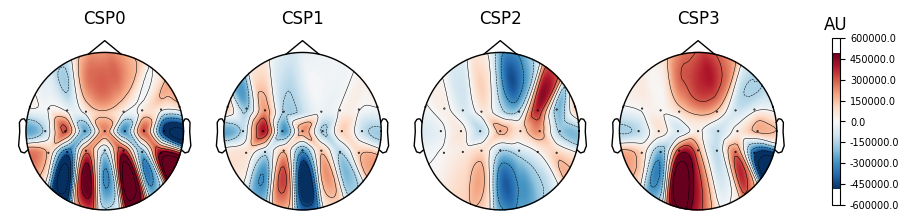

In [363]:
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(combined_preprocessing_dict['epochs'].info, units="Patterns (AU)", size=1.5)
csp.plot_filters(combined_preprocessing_dict['epochs'].info,  size=1.5)

Load an unseen data recording

In [330]:
recording_files[3]


'Gilad_ses-1_task-mi_run-004_eeg.xdf'

In [23]:
recording_files[311]


'NH_Block_3.xdf'

In [306]:
params_dict['recording_file']=recording_files[3]
train_inds,validation_inds,preprocessing_dict=run_pre_processing_extract_validation_set(recording_path,current_path,params_dict)
params_dict['events_triggers_dict']=preprocessing_dict['events_triggers_dict']


Creating RawArray with float64 data, n_channels=67, n_times=307260
    Range : 0 ... 307259 =      0.000 ...   614.518 secs
Ready.

###########################################################
removing subject sepecific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:

###########################################################
running csd
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 28 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 28.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up ba

In [301]:
preprocessing_dict

{'train_inds': array([ 0, 92, 98, 27, 63, 70, 18, 14, 36, 86, 53, 24, 87,  2, 75,  6, 19,
        61, 76, 12, 72, 29, 44,  8, 85, 89,  3, 28, 26, 54, 95, 59, 13, 73,
        11, 71, 16, 35, 99, 34, 60, 10, 39, 47, 25, 91, 56, 55,  4, 90, 58,
        96, 82, 97, 79,  5,  9,  7, 21, 84, 83, 69, 66, 50, 57, 88, 15, 30,
        48, 81, 20, 40, 68, 49, 45, 46, 94, 42, 52, 23], dtype=int64),
 'validation_inds':     label  original_trial_ind
 17      5                  17
 1       5                   1
 67      5                  67
 93      7                  93
 43      5                  43
 41      5                  41
 22      5                  22
 64      7                  64
 78      3                  78
 62      3                  62
 65      5                  65
 80      7                  80
 33      3                  33
 37      5                  37
 38      3                  38
 51      5                  51
 74      7                  74
 77      5                  77
 31

In [212]:
params_dict

{'LowPass': 8,
 'HighPass': 28,
 'PerformCsd': True,
 'filter_method': 'iir',
 'n_components': 4,
 'n_components_fbcsp': 4,
 'filters_bands': [[8, 12], [12, 20], [20, 28], [28, 32]],
 'Electorde_Group': ['FC5',
  'FC3',
  'FC1',
  'FC2',
  'FC4',
  'FC6',
  'FT7',
  'FT8',
  'C5',
  'C3',
  'C1',
  'Cz',
  'C2',
  'C4',
  'C6',
  'CP5',
  'CP3',
  'CP1',
  'CPz',
  'CP2',
  'CP4',
  'CP6'],
 'Electorde_Group_name': 'FC+C+CP',
 'epoch_tmin': -3,
 'epoch_tmax': 4,
 'classifier_window_s': 0.5,
 'classifier_window_e': 4.5,
 'augmentation_params': {'win_len': 1, 'win_step': 0.1},
 'windowed_prediction_params': {'win_len': 0.5, 'win_step': 0.1},
 'pipeline_name': 'csp+lda',
 'subject': 'Gilad',
 'recording_file': 'Gilad_ses-1_task-mi_run-004_eeg.xdf',
 'preprocessing_dict': {'train_inds': array([28, 38, 21, 33, 13, 19, 30, 15, 25, 22,  9, 24, 23,  1,  3, 32, 10,
         11,  6, 37, 14,  8, 34,  7, 12, 16, 39,  4,  5, 29, 27, 35],
        dtype=int64),
  'validation_inds':      label  origin

In [312]:
#plot the precision recall curve, and extract the relevant decision information into a dataframe

return_df=plot_precision_recall_curves_from_trained_classifier(preprocessing_dict,params_dict,precision_recall_curve_timerange=[0,4],trained_clf=trained_clf,predict_validation=False)
display(return_df)

data_to_predict=preprocessing_dict['epochs'].copy().crop(tmin=1,tmax=1.5).get_data()[:,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)

#note that here you can decide on which thresholds to use to better optimize your "real" usecase
thresholded_prediction
#prediction=trained_clf.predict(data_to_predict)

chosen window prediction range is [0, 4]
note that the prediction paramaters (that the classifier is trained on) are: {'win_len': 0.5, 'win_step': 0.1}
consider if you want the preciction range to match the prediction_param


,precision_0,precision_1,precision_2,recall_0,recall_1,recall_2,thresholds0,thresholds1,thresholds2
0,0.333333,0.333333,0.333333,1.0000,1.0000,1.0000,-3.680425,-3.415892,-4.095935
1,0.340426,0.319149,0.340426,1.0000,0.9375,1.0000,-3.635080,-2.945792,-3.982123
2,0.347826,0.326087,0.347826,1.0000,0.9375,1.0000,-3.615172,-2.937488,-3.535975
3,0.355556,0.333333,0.355556,1.0000,0.9375,1.0000,-3.037871,-2.443751,-3.506800
4,0.363636,0.340909,0.363636,1.0000,0.9375,1.0000,-2.981733,-2.423117,-3.400840
5,0.372093,0.348837,0.372093,1.0000,0.9375,1.0000,-2.967325,-2.393379,-3.379222
6,0.380952,0.357143,0.380952,1.0000,0.9375,1.0000,-2.782423,-2.376343,-3.303794
7,0.390244,0.365854,0.390244,1.0000,0.9375,1.0000,-2.768885,-2.264241,-3.206769
8,0.400000,0.375000,0.400000,1.0000,0.9375,1.0000,-2.636235,-2.188075,-3.148819
9,0.410256,0.384615,0.410256,1.0000,0.9375,1.0000,-2.584548,-2.000502,-3.126409


array([[-1.66885505, -0.67002798, -2.83698883],
       [-0.61358276, -1.72707685, -2.83521225],
       [ 0.70598611, -1.92947752, -3.95238045],
       [-3.70925883, -3.23446801,  1.76785498],
       [ 0.84784742, -2.85384166, -3.16987762],
       [-4.14847583, -0.20122182, -0.82617421],
       [-3.62294856,  2.74107904, -4.29400234],
       [-1.70546115, -0.62389059, -2.84652012],
       [-0.72713165, -1.49776493, -2.95097527],
       [-0.0889429 , -3.70028997, -1.38663899],
       [ 0.26171235, -2.97728158, -2.46030263],
       [-0.85588161, -0.38250558, -3.93748467],
       [-2.95990016, -4.52534993,  2.30937823],
       [ 0.43424467, -2.4821782 , -3.12793833],
       [-3.09899375, -2.83921406,  0.76233595],
       [-4.85224167, -1.05274395,  0.72911377],
       [-1.60080723, -0.78000652, -2.7950581 ],
       [-0.7927967 , -1.24480014, -3.13827501],
       [-0.61611292, -2.09754767, -2.46221127],
       [-2.9986638 , -0.90277122, -1.27443684],
       [-2.01668722, -0.65254664, -2.506

In [265]:
data_to_predict=preprocessing_dict['epochs'].copy().crop(tmin=0,tmax=4).get_data()[:,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)

#note that here you can decide on which thresholds to use to better optimize your "real" usecase
thresholded_prediction
prediction=trained_clf.decision_function(data_to_predict)

In [261]:
preprocessing_dict['epochs'].events[:,2]

array([6, 7, 6, 7, 3, 6, 6, 7, 6, 7, 3, 6, 6, 3, 6, 3, 3, 7, 3, 6, 6, 3,
       7, 6, 3, 7, 7, 6, 6, 3, 7, 7, 6, 6, 7, 6, 6, 7, 3, 3, 7, 6, 6, 3,
       3, 7, 7, 3, 3, 7, 3, 6, 3, 7, 3, 3, 7, 7, 3, 7])

In [266]:
prediction[:]

array([-2.05743089, -0.12092408, -2.02054044,  2.34173342, -2.80396141,
       -1.74096676, -3.37111042,  2.07014942, -2.31855942,  0.63621711,
       -1.72595665, -2.78840953,  1.38342753, -2.32474348, -3.75611439,
       -0.9167688 , -2.72777547,  2.80184057, -1.76689824,  0.66274782,
        0.50811884, -0.59933874,  2.16820401, -1.14912679, -3.7033061 ,
        1.63791111,  3.96670447, -0.05941875, -0.68133579, -2.86327701,
        3.62487583,  2.1970543 ,  1.71086867, -1.58216642,  2.51537739,
       -0.81337713, -2.22370315,  1.92836754, -4.69445101, -4.20238705,
        2.13025862,  0.79870441,  1.52976375, -1.86972182, -3.09414998,
        2.20597322,  0.70358176, -2.78933119, -2.00992266, -1.4253118 ,
       -1.57629581, -2.19308317, -0.03776897,  2.32050127, -1.74396613,
       -2.62600119,  4.04140005,  1.20334074, -3.72767294,  0.38627685])

In [245]:
params_dict['preprocessing_dict']['events_triggers_dict']=preprocessing_dict['events_triggers_dict']


In [246]:
win_step = params_dict['windowed_prediction_params'].get('win_step')
win_len = params_dict['windowed_prediction_params'].get('win_len')
sfreq=preprocessing_dict['epochs'].info['sfreq']
w_length = int(sfreq * win_len) 
w_step = int(sfreq * win_step)
w_start = np.arange(0, (preprocessing_dict['epochs'].get_data()[:].shape[2]) - w_length, w_step)


In [247]:
preprocessing_dict['epochs'].get_data().shape

(60, 22, 3501)

In [288]:
    epochs_copy=preprocessing_dict['epochs']
    train_inds=preprocessing_dict['train_inds']
    validation_inds=preprocessing_dict['validation_inds']['original_trial_ind'].values

    #crop the data according to the training window: 
    returned_dict=crop_the_data(epochs_copy,train_inds,validation_inds,params_dict['classifier_window_s'],params_dict['classifier_window_e']) #two more paramters here are tmin and tmax which are not used apparently. 
    

In [289]:
train_set_data=returned_dict['train_set_data_uncroped']
train_set_labels = preprocessing_dict['epochs'].events[:,2]
##train_set_labels=returned_dict['train_set_labels_uncroped']

In [290]:
triggers_label_dict={val:key for key,val in params_dict['preprocessing_dict']['events_triggers_dict'].items()} 
test_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in train_set_labels])


In [291]:
test_data_y_labels

array(['Rest', 'Rest', 'Right', 'Rest', 'Rest', 'Right', 'Rest', 'Left',
       'Rest', 'Rest', 'Rest', 'Right', 'Rest', 'Rest', 'Right', 'Rest',
       'Left', 'Rest', 'Rest', 'Rest', 'Left', 'Rest', 'Rest', 'Left',
       'Rest', 'Left', 'Rest', 'Right', 'Rest', 'Left', 'Rest', 'Rest',
       'Rest', 'Left', 'Rest', 'Right', 'Rest', 'Rest', 'Left', 'Rest',
       'Right', 'Rest', 'Right', 'Rest', 'Rest', 'Rest', 'Left', 'Rest',
       'Right', 'Rest', 'Right', 'Rest', 'Rest', 'Rest', 'Right', 'Rest',
       'Rest', 'Rest', 'Right', 'Rest', 'Left', 'Rest', 'Left', 'Rest',
       'Right', 'Rest', 'Rest', 'Rest', 'Left', 'Rest', 'Left', 'Rest',
       'Right', 'Rest', 'Right', 'Rest', 'Left', 'Rest', 'Left', 'Rest',
       'Right', 'Rest', 'Left', 'Rest', 'Rest', 'Left', 'Rest', 'Right',
       'Rest', 'Left', 'Rest', 'Left', 'Rest', 'Right', 'Rest', 'Right',
       'Rest', 'Left', 'Rest', 'Right'], dtype='<U5')

In [249]:
run_windowed_pretrained_classifier(trained_clf,train_set_data,test_data_y_labels,w_start,w_length)

ValueError: Found input variables with inconsistent numbers of samples: [60, 48]

In [250]:
run_windowed_pretrained_classifier(trained_clf,preprocessing_dict['epochs'].get_data()[:],test_data_y_labels,w_start,w_length)

([0.26666666666666666,
  0.26666666666666666,
  0.2833333333333333,
  0.26666666666666666,
  0.3333333333333333,
  0.35,
  0.3333333333333333,
  0.31666666666666665,
  0.31666666666666665,
  0.3333333333333333,
  0.3333333333333333,
  0.31666666666666665,
  0.36666666666666664,
  0.36666666666666664,
  0.35,
  0.38333333333333336,
  0.38333333333333336,
  0.4166666666666667,
  0.4,
  0.4166666666666667,
  0.4166666666666667,
  0.38333333333333336,
  0.36666666666666664,
  0.4,
  0.43333333333333335,
  0.5,
  0.5,
  0.5333333333333333,
  0.5333333333333333,
  0.5333333333333333,
  0.5166666666666667,
  0.5333333333333333,
  0.5666666666666667,
  0.5166666666666667,
  0.5,
  0.55,
  0.5333333333333333,
  0.5,
  0.5,
  0.4666666666666667,
  0.5,
  0.4666666666666667,
  0.5,
  0.5333333333333333,
  0.5333333333333333,
  0.5666666666666667,
  0.55,
  0.5666666666666667,
  0.5666666666666667,
  0.55,
  0.5,
  0.5,
  0.48333333333333334,
  0.4166666666666667,
  0.4,
  0.4166666666666667,
  0.

In [193]:
np.where(preprocessing_dict['epochs'].events == 6)


(array([ 1,  5,  6, 13, 14, 16, 19, 23, 24, 27, 34, 35, 37, 38, 39, 40, 42,
        48, 55, 59], dtype=int64),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       dtype=int64))

In [195]:
print(np.where(preprocessing_dict['epochs'].events[:,2] == 7)[0])


[ 0  3  4  7 10 11 12 15 18 20 25 26 29 33 36 41 46 54 56 57]


Examine for specific trials performance

In [200]:
print(preprocessing_dict['epochs'].events[:,2] )

[7 6 3 7 7 6 6 7 3 3 7 7 7 6 6 7 6 3 7 6 7 3 3 6 6 7 7 6 3 7 3 3 3 7 6 6 7
 6 6 6 6 7 6 3 3 3 7 3 6 3 3 3 3 3 7 6 7 7 3 6]


In [253]:
trained_clf.predict(data_to_predict[0:1,:,:])[0]

'Right'

In [196]:
prediction_array = []

# Define the start, end, and step size
time_start = 0
time_end = 3.5
time_step = 0.1

# Calculate the number of steps based on the start, end, and step size
num_steps = int((time_end - time_start) / time_step)
for i in range(num_steps):
    tmin = time_start + i * time_step
    data_to_predict=preprocessing_dict['epochs'].copy().crop(tmin,tmax=(tmin+0.5)).get_data()[:,:]
    prediction=trained_clf.predict_log_proba(data_to_predict)
    prediction_array.append(prediction)
prediction_array = np.array(prediction_array)

In [241]:
prediction_array[:,8]

array([[-0.02571878, -3.84543385, -5.5180298 ],
       [-0.04796107, -3.15042372, -5.52267848],
       [-0.14237432, -2.33515466, -3.32679693],
       [-0.28458332, -1.9796564 , -2.21132269],
       [-0.85311045, -1.23206958, -1.26505358],
       [-0.98020377, -1.37938221, -0.98609282],
       [-1.85896112, -2.54337287, -0.26714152],
       [-0.94491085, -2.77127357, -0.60019701],
       [-2.64941553, -3.43224664, -0.10870697],
       [-2.16702087, -3.48202433, -0.15696191],
       [-3.40779699, -4.34973405, -0.0471171 ],
       [-2.44922483, -3.56042853, -0.12192715],
       [-3.86833055, -4.30116157, -0.03505328],
       [-2.68136814, -3.92536107, -0.09233946],
       [-0.93810394, -2.61249191, -0.62496666],
       [-0.63401851, -1.65674042, -1.27731669],
       [-1.57315048, -1.6978606 , -0.49505981],
       [-1.016811  , -1.10604178, -1.17964685],
       [-0.78526441, -0.89577411, -1.99723893],
       [-0.93043313, -1.30022137, -1.09917542],
       [-1.62569162, -2.32324622, -0.349

In [39]:
prediction

array([[-3.39904242e-01, -1.25865222e+00, -5.49070625e+00],
       [-2.31116058e-01, -1.60808933e+00, -5.10229834e+00],
       [-1.77759797e+00, -3.66563651e+00, -2.16455451e-01],
       [-5.96135327e+00, -4.85546266e+00, -1.04162143e-02],
       [-4.74792897e-01, -1.19966687e+00, -2.56796348e+00],
       [-4.20157101e+00, -2.12245073e+00, -1.44690407e-01],
       [-4.13443842e+00, -4.84231195e-02, -3.46548753e+00],
       [-9.03727220e+00, -4.89617968e+00, -7.62296163e-03],
       [-3.14898067e+00, -8.15955831e-02, -3.33936243e+00],
       [-1.30592014e+00, -7.24640590e-01, -1.40822021e+00],
       [-5.65640061e-02, -3.79470156e+00, -3.42638021e+00],
       [-4.73560895e-01, -1.83998403e+00, -1.52142988e+00],
       [-2.07809133e+00, -4.53167715e+00, -1.46103232e-01],
       [-6.27487536e-01, -9.06282695e-01, -2.77989398e+00],
       [-8.28296008e-01, -5.76677500e-01, -6.53941577e+00],
       [-2.76497026e-01, -1.70940357e+00, -2.80361838e+00],
       [-9.37520093e-01, -1.99479359e+00

In [208]:
# Create an empty list to store the rows of the new array
new_rows = []
asterisk_locations = []

# Loop through each row in the original array
for i, row in enumerate(prediction_array[:,10,:]):
    # Find indices where values are higher than -0.5
    indices = np.where(row > -0.5)[0]
    
    # If there are no values higher than -0.5
    if len(indices) == 0:
        # Find the index of the maximum value
        max_index = np.argmax(row)
        # Append a new row with an asterisk and the index of the maximum value
        new_row = ['*' + str(3 if max_index == 0 else 6 if max_index == 1 else 7)]
        # Add the row index to the asterisk_locations list
        asterisk_locations.append(i)
    else:
        # Replace 0 with 3, 1 with 6, and 2 with 7
        indices = [3 if idx == 0 else 6 if idx == 1 else 7 for idx in indices]
        # Append a new row with the modified indices
        new_row = list(indices)

    # Append the new row to the list of rows
    new_rows.append(new_row)

# Convert the list of rows into a numpy array
new_array = np.array(new_rows)

# Print the new array
print(new_array[:])
print("Locations of asterisks:", asterisk_locations)
len(asterisk_locations)


[['7']
 ['7']
 ['7']
 ['7']
 ['7']
 ['7']
 ['7']
 ['*7']
 ['*6']
 ['6']
 ['6']
 ['6']
 ['6']
 ['3']
 ['3']
 ['*3']
 ['*3']
 ['*3']
 ['*7']
 ['7']
 ['7']
 ['*7']
 ['*3']
 ['*3']
 ['*7']
 ['*7']
 ['7']
 ['7']
 ['7']
 ['7']
 ['7']
 ['7']
 ['7']
 ['7']
 ['7']]
Locations of asterisks: [7, 8, 15, 16, 17, 18, 21, 22, 23, 24, 25]


11

In [23]:
print(np.where(new_array[:,0] == '7')[0])

NameError: name 'new_array' is not defined

In [156]:
prediction=trained_clf.predict(data_to_predict)
print(prediction)

['Right' 'Left' 'Left' 'Right' 'Left' 'Left' 'Resting' 'Right' 'Left'
 'Left' 'Right' 'Right' 'Resting' 'Resting' 'Resting' 'Resting' 'Resting'
 'Right' 'Right' 'Left' 'Left' 'Right' 'Left' 'Resting' 'Left' 'Right'
 'Right' 'Right' 'Left' 'Resting' 'Resting' 'Right' 'Left' 'Right'
 'Resting' 'Resting' 'Right' 'Right' 'Right' 'Resting' 'Right' 'Right'
 'Resting' 'Left' 'Left' 'Left' 'Left' 'Left' 'Right' 'Left' 'Left'
 'Right' 'Left' 'Left' 'Right' 'Left' 'Right' 'Right' 'Left' 'Resting']


In [162]:
array1 = np.where(preprocessing_dict['epochs'].events == 3)
array2 = np.where(prediction == 'Right')
## array2 = np.where(new_array[:,0] == '7')

# Values occur in both arrays
common_values = np.intersect1d(array1, array2)
count_common_values = len(common_values)

# Values occur only in array no.1
unique_values_array1 = np.setdiff1d(array1, array2)
count_unique_values_array1 = len(unique_values_array1)

# Values occur only in array no.2
unique_values_array2 = np.setdiff1d(array2, array1)
count_unique_values_array2 = len(unique_values_array2)

print(f"1. Values occur in both arrays: {count_common_values}")
print(f"2. Values occur only in array no.1: {count_unique_values_array1}")
print(f"3. Values occur only in array no.2: {count_unique_values_array2}")

1. Values occur in both arrays: 4
2. Values occur only in array no.1: 16
3. Values occur only in array no.2: 19


In [214]:
where_above_threshold_count_1 = np.where(column1 > threshold1)[0]
print(where_above_threshold_count_1)

NameError: name 'column1' is not defined

Compare prediction performance by threshold to that of .predict 

In [ ]:
data_to_predict=preprocessing_dict['epochs'].copy().crop(tmin=0.5,tmax=1).get_data()[:,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)

In [ ]:
column0 = thresholded_prediction[:, 0]
column1 = thresholded_prediction[:, 1]
column2 = thresholded_prediction[:, 2]

threshold0 = -0.976948	
threshold1 = -1.096539
threshold2 = -0.697421

above_threshold_count_0 = (column0 >= threshold0).sum()
above_threshold_count_1 = (column1 >= threshold1).sum()
above_threshold_count_2 = (column2 >= threshold2).sum()
print(above_threshold_count_0,above_threshold_count_1,above_threshold_count_2)

where_above_threshold_count_0 = np.where(column0 >= threshold0)[0]
where_above_threshold_count_1 = np.where(column1 >= threshold1)[0]
where_above_threshold_count_2 = np.where(column2 >= threshold2)[0]


24 24 11


In [ ]:
prediction=trained_clf.predict(data_to_predict)
prediction

array(['Left', 'Resting', 'Left', 'Resting', 'Left', 'Left', 'Resting',
       'Resting', 'Left', 'Right', 'Left', 'Resting', 'Left', 'Right',
       'Left', 'Left', 'Right', 'Resting', 'Left', 'Right', 'Right',
       'Right', 'Resting', 'Left', 'Left', 'Right', 'Right', 'Right',
       'Resting', 'Left', 'Right', 'Right', 'Resting', 'Left', 'Resting',
       'Left', 'Resting', 'Right', 'Resting', 'Left', 'Left', 'Resting',
       'Right', 'Left', 'Left', 'Resting', 'Right', 'Right', 'Resting',
       'Left', 'Right', 'Left', 'Left', 'Left', 'Left', 'Right', 'Right',
       'Left', 'Left', 'Left'], dtype='<U7')

    Using multitaper spectrum estimation with 7 DPSS windows


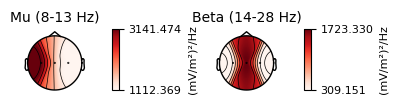

In [ ]:
combined_preprocessing_dict['epochs']['Left'].pick_channels(['C3','Cz','C4']).compute_psd(fmin=8, fmax=32, tmin=0,tmax=4).plot_topomap(bands = {'Mu (8-13 Hz)': (8, 13), 'Beta (14-28 Hz)': (14, 28)})

### run on a single participant - with a single recording file (no concatination of files is needed) 

In [ ]:
#cell is suitable for the old participants with a single recording file - dont use on roi! 
#uncomment the """ to use it: 


#define which subject to currently check: (here you can also try to define the filename explicitly, if you dont want to work with the "recording files list that is created earlier")
recording_file=recording_files[6]
Subject=subject_names[6]

print(f'iteration on subject: {recording_file}')
#put all in a single params_dictionary for the current run: 

#get all possible grid_search combinations: 
grid_search_dict_copy=grid_search_dict.copy()
all_grid_combinations = list(itertools.product(*all_options))
iteration_ind=0 #select some grid search combination - you can manualy change the params after getting the "params_dict" below

#here i can change manually the current iteration params: 
grid_search_dict_copy['Electorde_Groups_names_grid']=['C+CP+PO+P']
grid_search_dict_copy['filters_bands']=[[[8,12],[12,20]]]#[[[8,12], [12, 16],[16,20],[20,24],[24,28],[28,32]]]
#this cell allow to test specific iterations
params_dict=set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict_copy)
#remember - you can change param_dict manualy - ALL of its keys, so before examining your iteration, make sure that you manually adressed all the relevant keys to change. 
params_dict['subject']=Subject
params_dict['recording_file']=recording_file
params_dict['augmentation_params']={'win_len': 1, 'win_step': 0.1}
params_dict['classifier_window_s']=1
params_dict['classifier_window_e']=3
params_dict['pipeline_name']='csp+lda'
params_dict['n_components_fbcsp']=4
print('running a single iteration with the following paramaters:',params_dict)

#test it: 
train_inds,validation_inds,preprocessing_dict=run_pre_processing_extract_validation_set(recording_path,current_path,params_dict)
params_dict['preprocessing_dict']=preprocessing_dict
fig,w_times,scores_windows,folds_confusion_metrices_per_window,validation_scores,validation_confusion_metrices_per_window,trained_clf=run_training_and_classification_on_selected_params(params_dict,preprocessing_dict,to_plot=True,figure_outputs_path=figure_outputs_path,fig_name='test')


iteration on subject: NH_Block_Default.xdf
setting up current params: iteration 0 - grid settings: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
running a single iteration with the following paramaters: {'LowPass': 7, 'HighPass': 32, 'PerformCsd': True, 'filter_method': 'iir', 'n_components': 4, 'n_components_fbcsp': 4, 'filters_bands': [[8, 12], [12, 20]], 'Electorde_Group': ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP7', 'TP8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'], 'Electorde_Group_name': 'C+CP+PO+P', 'epoch_tmin': -3, 'epoch_tmax': 4, 'classifier_window_s': 1, 'classifier_window_e': 3, 'augmentation_params': {'win_len': 1, 'win_step': 0.1}, 'windowed_prediction_params': {'win_len': 0.5, 'win_step': 0.1}, 'pipeline_name': 'csp+lda', 'subject': 'NH', 'recording_file': 'NH_Block_Default.xdf'}


Exception: file c:\Users\gilad\MI-VR_Project\Recordings\NH_Block_Default.xdf does not exist.

In [ ]:
#example of how to plot a confusion  matrix from the first fold (training set) on the first window
disp=ConfusionMatrixDisplay(folds_confusion_metrices_per_window[1][0],display_labels=trained_clf.classes_)
disp.plot()
plt.show()

disp=ConfusionMatrixDisplay(np.array(validation_confusion_metrices_per_window).mean(axis=0),display_labels=trained_clf.classes_)
disp.plot()
plt.show()

In [ ]:
#plot and extract relevfant decision information for the precision recall curve - this time suited to 2 classes (binary classification) - which basicly means that the output score is single (and not 2 scores are you  might have expected)
return_df=plot_precision_recall_curves_from_trained_classifier(preprocessing_dict,params_dict,precision_recall_curve_timerange=[1,2],trained_clf=trained_clf,predict_validation=True)
display(return_df)

data_to_predict=preprocessing_dict['epochs'].copy().crop(tmin=0,tmax=4).get_data()[:,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)<0.520642 #example of how to use a custom threshold you extracted from the return_df
prediction=trained_clf.predict(data_to_predict)

#show the difference between the custom and the default prediction thresholds.  
pd.DataFrame({'thresholded':thresholded_prediction,'default':prediction})

chosen window prediction range is [1, 2]
note that the prediction paramaters (that the classifier is trained on) are: {'win_len': 0.5, 'win_step': 0.1}
consider if you want the preciction range to match the prediction_param


IndexError: index 167 is out of bounds for axis 0 with size 60

## this section runs custom grid search for neta: 
### didnt update this code to work with the combined_preprocessing_structure of roi (shouldnt be too much changes needed)
#### defines a custom grid 
#### define the participant name and file 
#### run the grid search 

In [15]:
#simple named groups: 
Electorde_Groups = {'FP': ['Fp1', 'Fp2'],
                   'AF': ['AF7', 'AF3', 'AFz', 'AF4', 'AF8'],
                   'F' : ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],
                   'FC': ['FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT7','FT8'],
                   'C' : ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4' ,'C6'],
                   'CP': ['CP5', 'CP3', 'CP1','CPz', 'CP2', 'CP4', 'CP6'],
                   'P' : ['P7', 'P5','P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
                   'PO': ['PO7', 'PO3', 'POz', 'PO4', 'PO8'],
                   'O' : ['Oz', 'O2', 'O1', 'Iz']
                  } 
#set up custom group names: 
Electorde_Groups = {'Motor_cortex':['F3', 'F1', 'Fz', 'F2', 'F4']+['FC3', 'FC1', 'FC2', 'FC4']+['C3', 'C1', 'Cz', 'C2', 'C4']+
                    ['CP3', 'CP1','CPz', 'CP2', 'CP4']+['P3', 'P1', 'Pz', 'P2', 'P4'],
                    'Motor_cortex_extended': ['F3', 'F1', 'Fz', 'F2', 'F4']+['FC3', 'FC1', 'FC2', 'FC4']+['C5','C3', 'C1', 'Cz', 'C2', 'C4','C6']+
                    ['CP3', 'CP1','CPz', 'CP2', 'CP4']+['P3', 'P1', 'Pz', 'P2', 'P4'],
                    'Visual_cortex': ['P7', 'P5','P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8']+['PO7', 'PO3', 'POz', 'PO4', 'PO8']+['Oz', 'O2', 'O1', 'Iz'],
                    'all':  ['Fp1', 'Fp2']+['AF7', 'AF3', 'AFz', 'AF4', 'AF8']+ ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8']+
                    ['FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT7','FT8']+['C5', 'C3', 'C1', 'Cz', 'C2', 'C4' ,'C6']+['CP5', 'CP3', 'CP1','CPz', 'CP2', 'CP4', 'CP6']+
                    ['P7', 'P5','P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8']+['PO7', 'PO3', 'POz', 'PO4', 'PO8']+['Oz', 'O2', 'O1', 'Iz'],
                    'Motor_cortex_extended_po': ['F3', 'F1', 'Fz', 'F2', 'F4']+['FC3', 'FC1', 'FC2', 'FC4']+['C5','C3', 'C1', 'Cz', 'C2', 'C4','C6']+
                    ['CP3', 'CP1','CPz', 'CP2', 'CP4']+['P3', 'P1', 'Pz', 'P2', 'P4']+['PO3', 'POz', 'PO4']}



#set the current search: 
grid_search_dict=OrderedDict()
grid_search_dict={'filter_methods':['iir'], #['irr' or 'fir']
                'run_csd':[True],
                'pipeline_name':['csp+lda','ts+lda'],#'fbcsp+lda'], #these classifiers pipelines are defined in "run_windowed_classification_on_fold"
                #things to do: filter bank csp + lda, csp+ts+lda
                'bandpass_borders_grid':[[7,32],[8,30]], #each list defines the low and high cutoffs
                'Electorde_Groups_names_grid':['Motor_cortex','Motor_cortex_extended','Motor_cortex_extended_po','all'], #each "name" refers to an elec group defined above
                'n_components_grid':[4,6], #the n component options for the csp classifier
                'n_components_fbcsp_grid':[2], # the n components options to use in the fbcsp classifier (n * filter_bank_bands)\
                'filters_bands':[[[8, 12], [12, 20], [20, 32]]],
                'epoch_tmins_and_maxes_grid':[[-3,4]], #times (sec: pre,post) for initial epoching (this should be the longest epoch as the windowed prediction will be tested on it)
                'classifier_training_windows_grid':[[0.5 , 3.5],[1,4]], #what times(sec: start,end) to use for the classifer training (data augmentation is also using this window)
                'augmentation_windows_grid':[[1,0.2],[1,0.1]], #referes to proportions (win_len,win_step) of sfreq, [1,1] means taking the classification epochs, and creating 1 second long epochs with 1 second long steps
                'windowed_prediction_params':[[1,0.1]]} #refers to prportions (win_len,win_step) of sfreq to try and predict i.e. 0.5 = half a second window, with a 100ms steps  

all_options=[list(range(len(val))) for key,val in grid_search_dict.items()]
print(f'grid options {all_options}')
#get all possible grid_search combinations: 
all_grid_combinations = list(itertools.product(*all_options))
print(f'number of grid search iterations: {len(all_grid_combinations)}')

grid options [[0], [0], [0, 1], [0, 1], [0, 1, 2, 3], [0, 1], [0], [0], [0], [0, 1], [0, 1], [0]]
number of grid search iterations: 128


### run a grid search on a single participant

In [ ]:
Subject_name='Neta'
recording_file_name='Neta_NoAO_1Hand.xdf'
grid_search_data_frame_info=run_grid_search_on_single_participant(grid_search_dict,recording_file_name,Subject_name,save_every_n_iter=5,save_location_path=hyper_param_search_output,to_plot=False)
display(grid_search_data_frame_info)

In [ ]:
grid_search_data_frame_info

# run the entire grid search (on all participants): save the outcomes in a table

In [ ]:
for recording_file,Subject in tqdm(zip(recording_files,subject_names)): #run on all participants: 
    Subject_name=Subject
    recording_file_name=recording_file
    grid_search_data_frame_info=run_grid_search_on_single_participant(grid_search_dict,recording_file_name,Subject_name,save_every_n_iter=5,save_location_path=hyper_param_search_output,to_plot=True)
    

## take all the rest of the code from here: 


the cells below load up the grid search to look for the best hyper paramaters: 

In [ ]:
subject_specific_hyper_param_csvs=[curr_csv for curr_csv in hyper_param_search_output.iterdir() if (('.csv' in curr_csv.name))]
print(subject_specific_hyper_param_csvs)

#read the saved dataframes: also note that when cells with np array were saved, they are read out as strings so we need to convert them back to np arrays for easy of use
def convert_saved_string_to_np_array(string):
    array_format=np.array([float(num) for num in string.replace('[','').replace(']','').replace('\n','').split(' ') if len(num)>0])
    return array_format
#this section loads and concatinate all hyper params searchs into a single df
subjects_df_all=pd.concat([pd.read_csv(curr_csv,index_col=0,dtype={ 'mean_scores':object,
       'std_scores':object, 'w_times':object,'validation_scores':object},converters={ 'mean_scores':convert_saved_string_to_np_array,
       'std_scores':convert_saved_string_to_np_array, 'w_times':convert_saved_string_to_np_array,'validation_scores':convert_saved_string_to_np_array}) for curr_csv in subject_specific_hyper_param_csvs],axis=0)
subjects_df_all.reset_index(inplace=True)

[WindowsPath('c:/Users/d_abe/Desktop/mental imagery project/MI-VR_Project/hyper_param_search_outputs/best_hyper_params_max_prediction.csv'), WindowsPath('c:/Users/d_abe/Desktop/mental imagery project/MI-VR_Project/hyper_param_search_outputs/best_hyper_params_mean_prediction.csv'), WindowsPath('c:/Users/d_abe/Desktop/mental imagery project/MI-VR_Project/hyper_param_search_outputs/hypter_param_search_Dekel_AO.csv'), WindowsPath('c:/Users/d_abe/Desktop/mental imagery project/MI-VR_Project/hyper_param_search_outputs/hypter_param_search_Dekel_AoNoMI.csv'), WindowsPath('c:/Users/d_abe/Desktop/mental imagery project/MI-VR_Project/hyper_param_search_outputs/hypter_param_search_Dekel_NoAO.csv'), WindowsPath('c:/Users/d_abe/Desktop/mental imagery project/MI-VR_Project/hyper_param_search_outputs/hypter_param_search_Gilad_AO.csv'), WindowsPath('c:/Users/d_abe/Desktop/mental imagery project/MI-VR_Project/hyper_param_search_outputs/hypter_param_search_Neta_AO_1Hand.csv'), WindowsPath('c:/Users/d_abe

In [ ]:
#this section create functions used to infer the w_times vector (the time stamp of the middle of a prediction window) based on the
#prediction paramaters in the dataframe

def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False
    
def calculate_w_times(row):
        min_time = row['epoch_tmin']
        max_time = row['epoch_tmax']
        pred_win_string = row['windowed_prediction_params'].replace('{','').replace('}','').replace(',','')
        pred_win_len = [float(x) for x in pred_win_string.split(':')[1].split(' ') if isfloat(x)][0]
        pred_win_step = [float(x) for x in pred_win_string.split(':')[2].split(' ') if isfloat(x)][0]
        first_window = min_time 
        last_window = max_time - pred_win_len 
        w_times = np.linspace(first_window,last_window,row['mean_scores'].shape[0])
        assert(row['mean_scores'].shape==w_times.shape)
        return w_times

#this is where we define a function to search for the best performence over a requested window (prediction window defined by the timestamp of its start)
def get_performence_in_time_window(subjects_df_all,time_window,operation='mean'):
    #time window defineds the time stamp of the start of the window
    #possible operations: "mean",'max','min'
    
    values=subjects_df_all['mean_scores'].values
    times=subjects_df_all['w_times'].values
    extracted_values=[]
    for curr_times,curr_values in zip(times,values): 
        rel_values=curr_values[(curr_times>time_window[0]) & (curr_times<=time_window[1])]
        if operation=='mean':
            val=np.mean(rel_values)
        elif operation=='max':
            val=np.max(rel_values)
        elif operation=='min':
            val=np.min(rel_values)    
        extracted_values.append(val)
    return extracted_values
    


In [ ]:
#infer w_times
subjects_df_all['w_times'] = subjects_df_all.apply(calculate_w_times, axis=1)
time_window=[1,4]
max_col_name='max'+'_'+str(time_window[0])+'_'+str(time_window[1])
mean_col_name='mean'+'_'+str(time_window[0])+'_'+str(time_window[1])
subjects_df_all[max_col_name]= get_performence_in_time_window(subjects_df_all,time_window,operation='max') 
subjects_df_all[mean_col_name]= get_performence_in_time_window(subjects_df_all,time_window,operation='mean') 
grouped_df=subjects_df_all.groupby(['recording_file']).aggregate({max_col_name:['max','idxmax'],mean_col_name:['max','idxmax']})
print(grouped_df)
#best hyperparams per subject: 
best_hyper_params_df_mean_prediction=subjects_df_all.iloc[grouped_df[(mean_col_name,'idxmax')].values]
best_hyper_params_df_mean_prediction.to_csv(hyper_param_search_output/'best_hyper_params_mean_prediction.csv',index=False)
best_hyper_params_df_max_prediction=subjects_df_all.iloc[grouped_df[(max_col_name,'idxmax')].values]
best_hyper_params_df_max_prediction.to_csv(hyper_param_search_output/'best_hyper_params_max_prediction.csv',index=False)



                      max_1_4         mean_1_4       
                          max idxmax       max idxmax
recording_file                                       
Dekel_AO.xdf          0.68750      0  0.653750      8
Dekel_AoNoMI.xdf      0.68750      1  0.585000      9
Dekel_NoAO.xdf        0.74375      2  0.685312      2
Gilad_AO.xdf          0.88750      3  0.789687     11
Neta_AO_1Hand.xdf     0.68750      4  0.597187     12
Neta_AO_2Hands.xdf    0.76875      5  0.669063     13
Neta_NoAO_1Hand.xdf   0.71250      6  0.572283     14
Neta_NoAO_2Hands.xdf  0.66250      7  0.536875     15


In [ ]:
#define a function to take the "best_hyper_params_df_max_prediction" and the required index to plot the results
def plot_prediction_time_course_from_hyper_param_search(hyper_param_seach_df,ind):
    plot_df=pd.DataFrame({'w_times':hyper_param_seach_df.loc[ind]['w_times'],
                        'mean_scores':hyper_param_seach_df.loc[ind]['mean_scores'],
                        'std_scores':hyper_param_seach_df.loc[ind]['std_scores'],
                        'validation_scores':hyper_param_seach_df.loc[ind]['validation_scores']})
    fig=plt.figure()
    plt.fill_between(plot_df['w_times'],plot_df['mean_scores']+plot_df['std_scores'],plot_df['mean_scores']-plot_df['std_scores'],alpha=0.25,label=' +-1 std')
    sns.lineplot(data=plot_df,x='w_times',y='mean_scores',label='mean cv score',color='g')
    sns.lineplot(data=plot_df,x='w_times',y='validation_scores',color='r',label='validation set score')
    plt.legend(loc='upper left')
    plt.grid()
    plt.axhline(y=0.5, color='k', linestyle='--')
    plt.axvline(x=0,color='k', linestyle='-.')

    #get info for title: 
    filename=hyper_param_seach_df.loc[ind]['recording_file']
    max_col_name=[col for col in hyper_param_seach_df.columns if 'max_' in col]
    mean_col_name=[col for col in hyper_param_seach_df.columns if (('mean_' in col) and ('scores' not in col))]

    max_value=hyper_param_seach_df.loc[ind][max_col_name].values
    mean_value=hyper_param_seach_df.loc[ind][mean_col_name].values
    prediction_win_params=hyper_param_seach_df.loc[ind]['windowed_prediction_params']
    pred_win_string = prediction_win_params.replace('{','').replace('}','').replace(',','')
    pred_win_len = [float(x) for x in pred_win_string.split(':')[1].split(' ') if isfloat(x)][0]
    pred_win_step = [float(x) for x in pred_win_string.split(':')[2].split(' ') if isfloat(x)][0]

    title=f'{filename}\nwin_size = {pred_win_len}, step_size={pred_win_step}\ncv scores:\n{max_col_name}={max_value},{mean_col_name}={mean_value}'
    plt.title(title)

In [ ]:
#testing it (using the(3rd row - gilad AO, as it looks awesome! :P)) 
plot_prediction_time_course_from_hyper_param_search(best_hyper_params_df_mean_prediction,best_hyper_params_df_mean_prediction.index[3])